In [3]:
# STEP 1: Import Libraries
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

2025-08-31 11:45:38.842368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756640739.168527      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756640739.252856      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# STEP 2: Load Dataset
# ==============================
train_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")
test_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")

# Add ".jpg" extension to filenames
train_df['image_id'] = train_df['image_id'].apply(lambda x: str(x) + ".jpg")
test_df['image_id'] = test_df['image_id'].apply(lambda x: str(x) + ".jpg")

print("Train CSV:\n", train_df.head())
print("\nTest CSV:\n", test_df.head())

Train CSV:
       image_id  healthy  multiple_diseases  rust  scab
0  Train_0.jpg        0                  0     0     1
1  Train_1.jpg        0                  1     0     0
2  Train_2.jpg        1                  0     0     0
3  Train_3.jpg        0                  0     1     0
4  Train_4.jpg        1                  0     0     0

Test CSV:
      image_id
0  Test_0.jpg
1  Test_1.jpg
2  Test_2.jpg
3  Test_3.jpg
4  Test_4.jpg


In [5]:
# STEP 3: Check Images Folder
# ==============================
print(os.listdir("/kaggle/input/plant-pathology-2020-fgvc7")[:10])
print("Total train images:", len(os.listdir("/kaggle/input/plant-pathology-2020-fgvc7/images")))


['sample_submission.csv', 'images', 'train.csv', 'test.csv']
Total train images: 3642


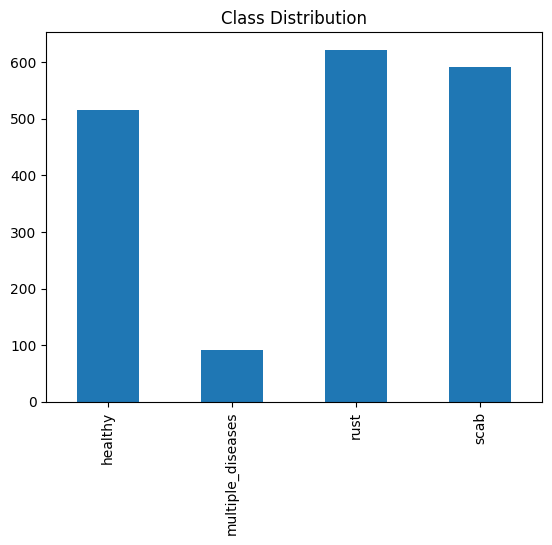

In [6]:
# STEP 4: Visualize Class Distribution
# ==============================
train_df.drop('image_id', axis=1).sum().plot(kind='bar')
plt.title("Class Distribution")
plt.show()

In [8]:
# STEP 5: Data Preprocessing
# ==============================
IMG_SIZE = 128
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # 20% for validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/plant-pathology-2020-fgvc7/images",
    x_col="image_id",
    y_col=["healthy","multiple_diseases","rust","scab"],
    subset="training",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

val_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/plant-pathology-2020-fgvc7/images",
    x_col="image_id",
    y_col=["healthy","multiple_diseases","rust","scab"],
    subset="validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw"
)


Found 1457 validated image filenames.
Found 364 validated image filenames.


In [9]:
# STEP 6: Build CNN Model
# ==============================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')   # 4 classes
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-31 11:46:59.604298: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,052 (12.61 MB)

 Trainable params: 3,305,604 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# STEP 7: Train Model
# ==============================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6483 - loss: 0.9507 - val_accuracy: 0.6126 - val_loss: 0.9676
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.6698 - loss: 0.8790 - val_accuracy: 0.6593 - val_loss: 0.8567
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6868 - loss: 0.7864 - val_accuracy: 0.5247 - val_loss: 1.1182
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.6678 - loss: 0.8012 - val_accuracy: 0.4313 - val_loss: 1.8003
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7269 - loss: 0.8050 - val_accuracy: 0.6538 - val_loss: 1.2178
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6871 - loss: 0.8325 - val_accuracy: 0.4396 - val_loss: 1.3609
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7172 - loss: 0.7639 - val_accuracy: 0.5659 - val_loss: 0.9255
Epoch 8/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7387 - loss: 0.6664 - val_accuracy: 0.6374 - val_loss:

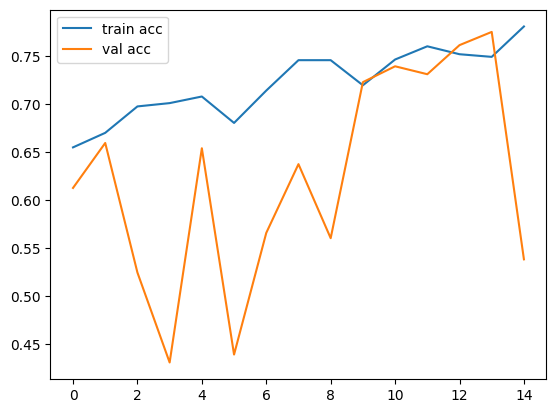

In [12]:
# STEP 8: Training Curves
# ==============================
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [13]:
# STEP 9: Predict on Test Set
# ==============================
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/kaggle/input/plant-pathology-2020-fgvc7/images",
    x_col="image_id",
    y_col=None,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    shuffle=False
)

preds = model.predict(test_gen, verbose=1)


Found 1821 validated image filenames.
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step


In [14]:
# STEP 10: Save Submission
# ==============================
submission = pd.DataFrame(preds, columns=["healthy","multiple_diseases","rust","scab"])
submission.insert(0, 'image_id', test_df['image_id'])
submission.to_csv("submission.csv", index=False)

print("✅ Submission file saved: submission.csv")

✅ Submission file saved: submission.csv
